In [1]:
import numpy as np
import torch
import torch.nn as nn
import tiktoken

from utilities import supporting_modules as sm

In [2]:
gpt_config_124M = {
    'vocab_size': 50257,
    'context_length': 1024,
    'emb_dim': 768, 
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

- "context_length" denotes the maximum number of input tokens the
model can handle, via the positional embeddings discussed in chapter 2.
- "emb_dim" represents the embedding size, transforming each token into
a 768-dimensional vector.
- "n_heads" indicates the count of attention heads in the multi-head
attention mechanism, as implemented in chapter 3.
- "n_layers" specifies the number of transformer blocks in the model,
which will be elaborated on in upcoming sections.

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
batch.shape

torch.Size([2, 4])

(bactch_size, num_tokens) ---> [GPT ARCHITECTURE] ---> (batch_size, num_tokens, vocab_size)
We input token ids and get token embeddings as output.

In [4]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        vocab_size, context_length, emb_dim, num_heads, n_layers, drop_rate, qkv_bias = cfg.values()
        self.tok_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(context_length, emb_dim)
        self.dropout = nn.Dropout(drop_rate)
        self.trf_blocks = nn.Sequential(
        *[sm.TransformerBlock(cfg) for _ in range(n_layers)]
        )
        self.final_norm = sm.LayerNorm(emb_dim)
        self.out_head = nn.Linear(emb_dim, vocab_size)

    def forward(self, in_ids):  # in_ids = input token ids
        batch_size, sequence_len =in_ids.shape
        token_embeds = self.tok_emb(in_ids)
        position_embeds = self.pos_emb(torch.arange(sequence_len, device=in_ids.device))
        x = token_embeds+position_embeds
        x = self.dropout(x)

        x = self.trf_blocks(x)

        x = self.final_norm(x)
        x = self.out_head(x)
        
        
        return x
        

In [5]:
model =GPTModel(gpt_config_124M)


In [6]:
model(batch).shape

torch.Size([2, 4, 50257])

In [7]:
# Analyzing the model
total_params = sum(p.numel() for p in model.parameters())
print('Total number of parameters: ', total_params)

Total number of parameters:  163059793


In [8]:
# Weight tying mechanism: reusing weights from the token embeddings into output layer
print("Embedding layer weights shape: ", model.tok_emb.weight.shape)
print("Output layer shape: ", model.out_head.weight.shape)

Embedding layer weights shape:  torch.Size([50257, 768])
Output layer shape:  torch.Size([50257, 768])


As we can see weights of both the layers have the same shape. now extracting last layer weights from total parameters

In [9]:
gpt2_total_parameters=total_params-sum(p.numel() for p in model.out_head.parameters())
gpt2_total_parameters

124412160

In [10]:
# compute the memory requirements of the 163 million
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 622.02 MB


### Generating Text
The process by which a GPT model goes from output tensors to generated
<br> text involves several steps:
- Decoding the output tensors
- selecting the tokens based on probability distribution
- converting these tokens into human-readable text

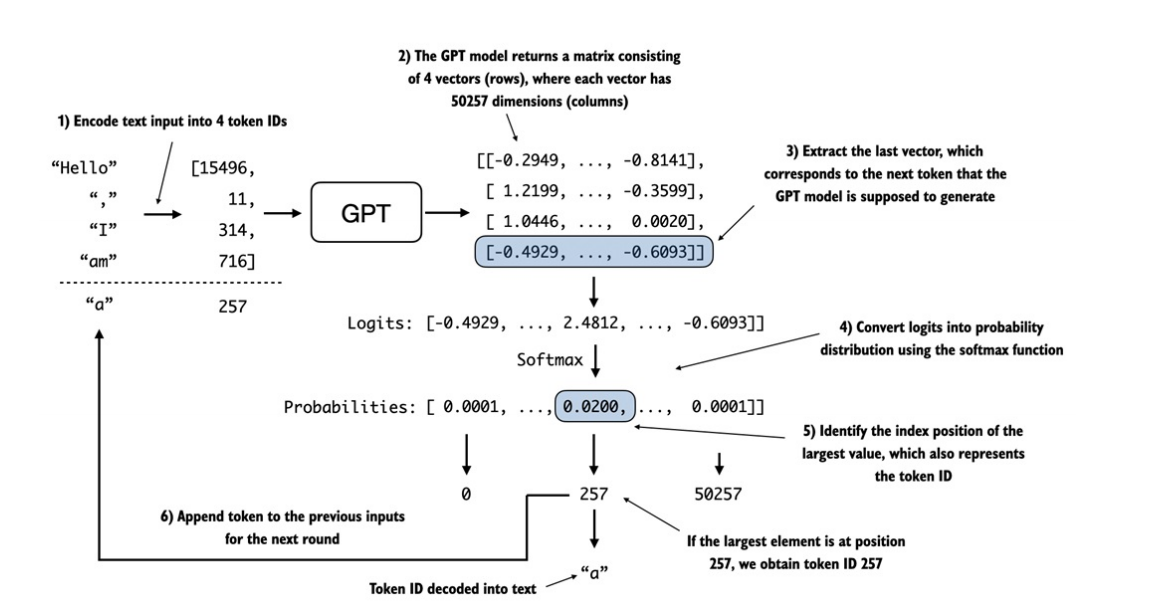

In [32]:
def generate_text(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :] #C
        probas = torch.softmax(logits, dim=-1) #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #E
        idx = torch.cat((idx, idx_next), dim=1) #F
    return idx

In [33]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print('encoded: ', encoded)
encoded_tensor=torch.tensor(encoded).unsqueeze(0)


encoded:  [15496, 11, 314, 716]


In [35]:
# put the model on .eval() mode to disable random components (dropout etc) which are only used during training

model.eval()
out = generate_text(model, encoded_tensor, max_new_tokens=6, context_size=gpt_config_124M['context_length'])

In [40]:
tokenizer.decode(out.squeeze(0).tolist())

'Hello, I amうaji Cardiff purposefully� gam'